In [1]:
import nbsetup
from models.sparc.result import Result
from models.sparc.mcmc import mcmc
from models.sparc.analysis import Analysis

In [2]:
default = Result()

In [3]:
DATASET = 'Quality'

In [4]:
model = mcmc(default.datasets()[DATASET], train_epsilon=True, train_tau=True)

In [5]:
analysis = Analysis('MCMC', model)

In [6]:
found = analysis.Result(fast=True)
print(analysis.uni)


{'gamma': array(84.83573901), 'alpha': array(0.27469966), 'epsilon': array(19.96339838)}


In [7]:
analysis.adjs

,Galaxy,Inc,tau,Source
0,CamB,21.893061,0.136608,MCMC
1,DDO064,54.094884,0.143117,MCMC
2,DDO154,62.875566,5.934867,MCMC
3,DDO161,39.884157,29.649773,MCMC
4,DDO168,47.791689,0.134792,MCMC
...,...,...,...,...
123,UGC11914,18.756953,0.150020,MCMC
124,UGC12632,23.445548,0.152896,MCMC
125,UGC12732,25.619961,0.149162,MCMC
126,UGCA442,20.897569,0.161105,MCMC


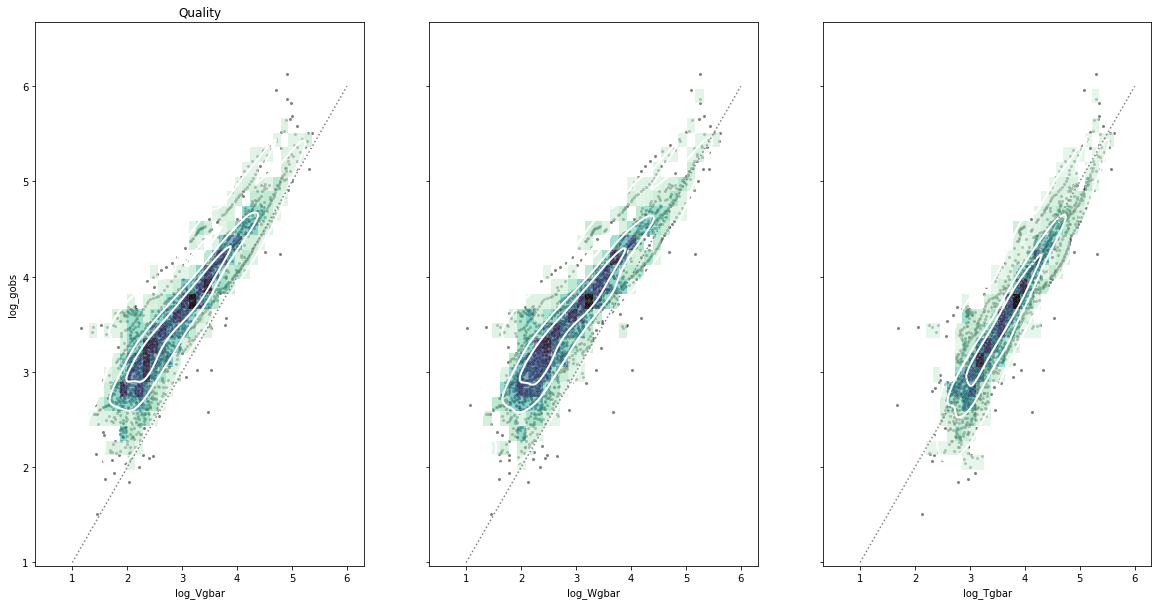

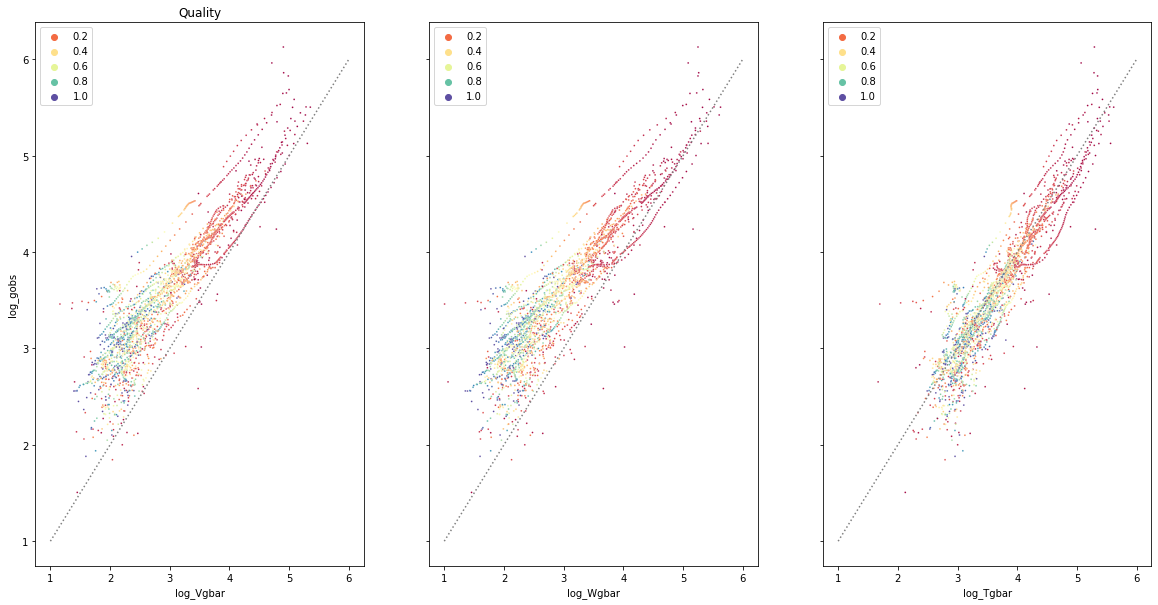

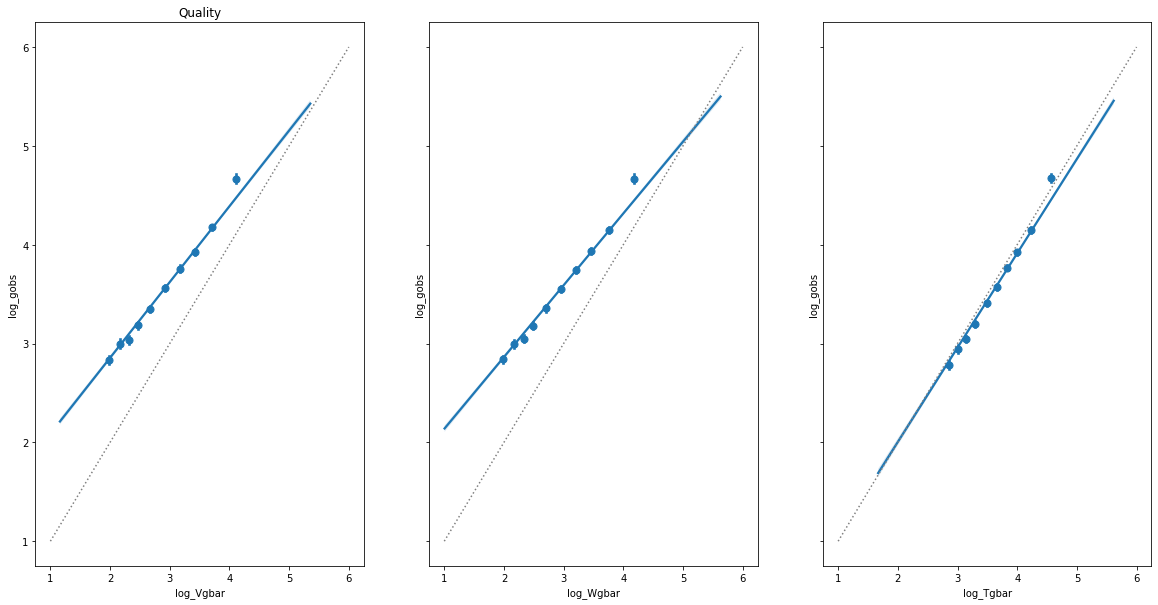

In [6]:
found.plot_rars(query_key=DATASET)

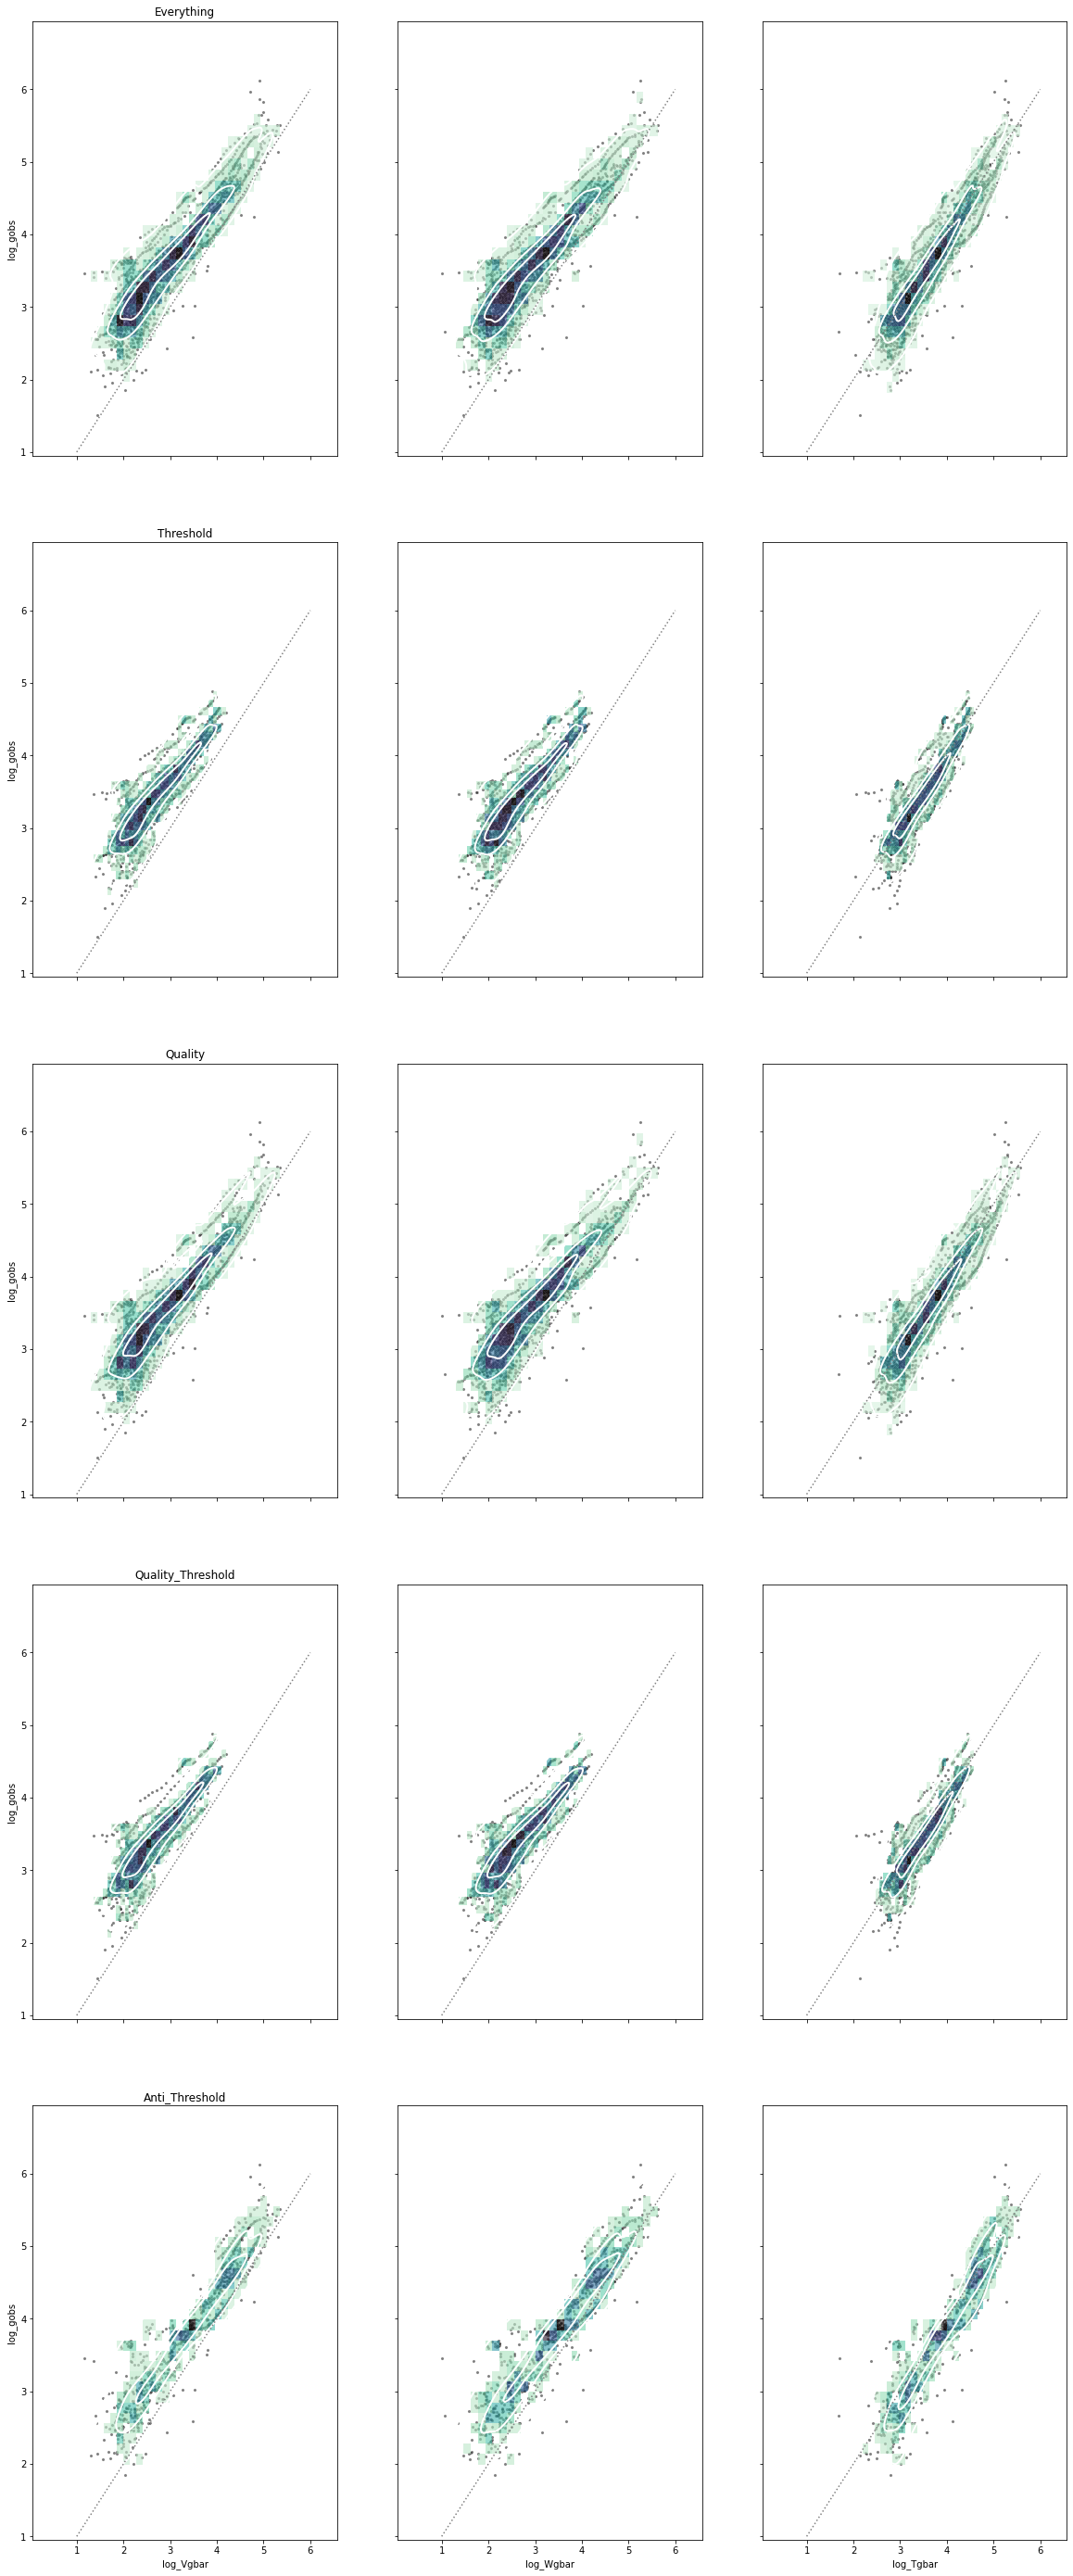

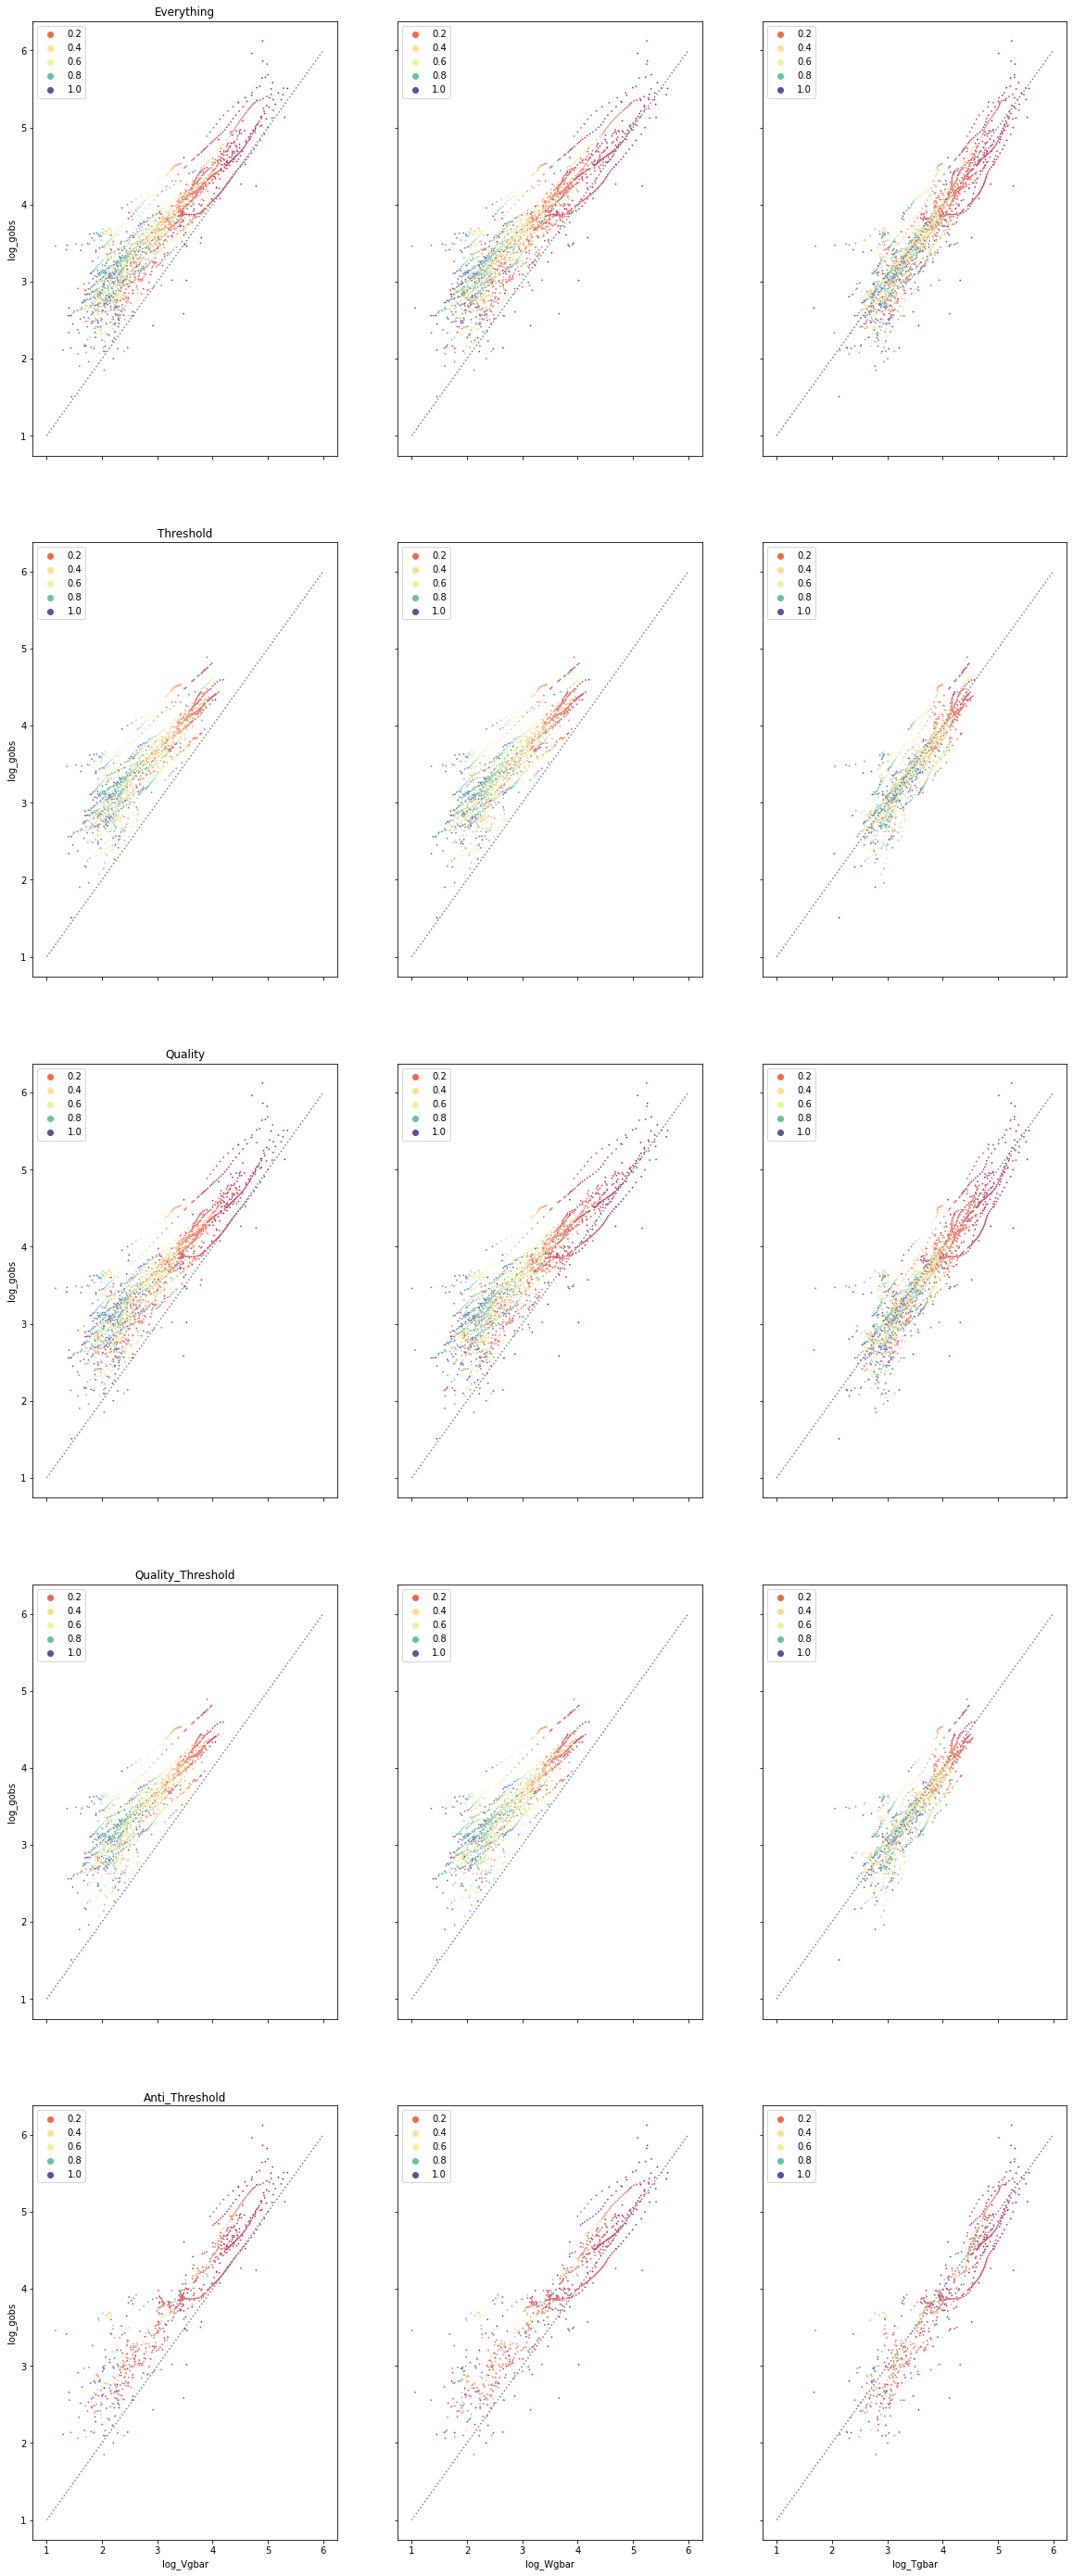

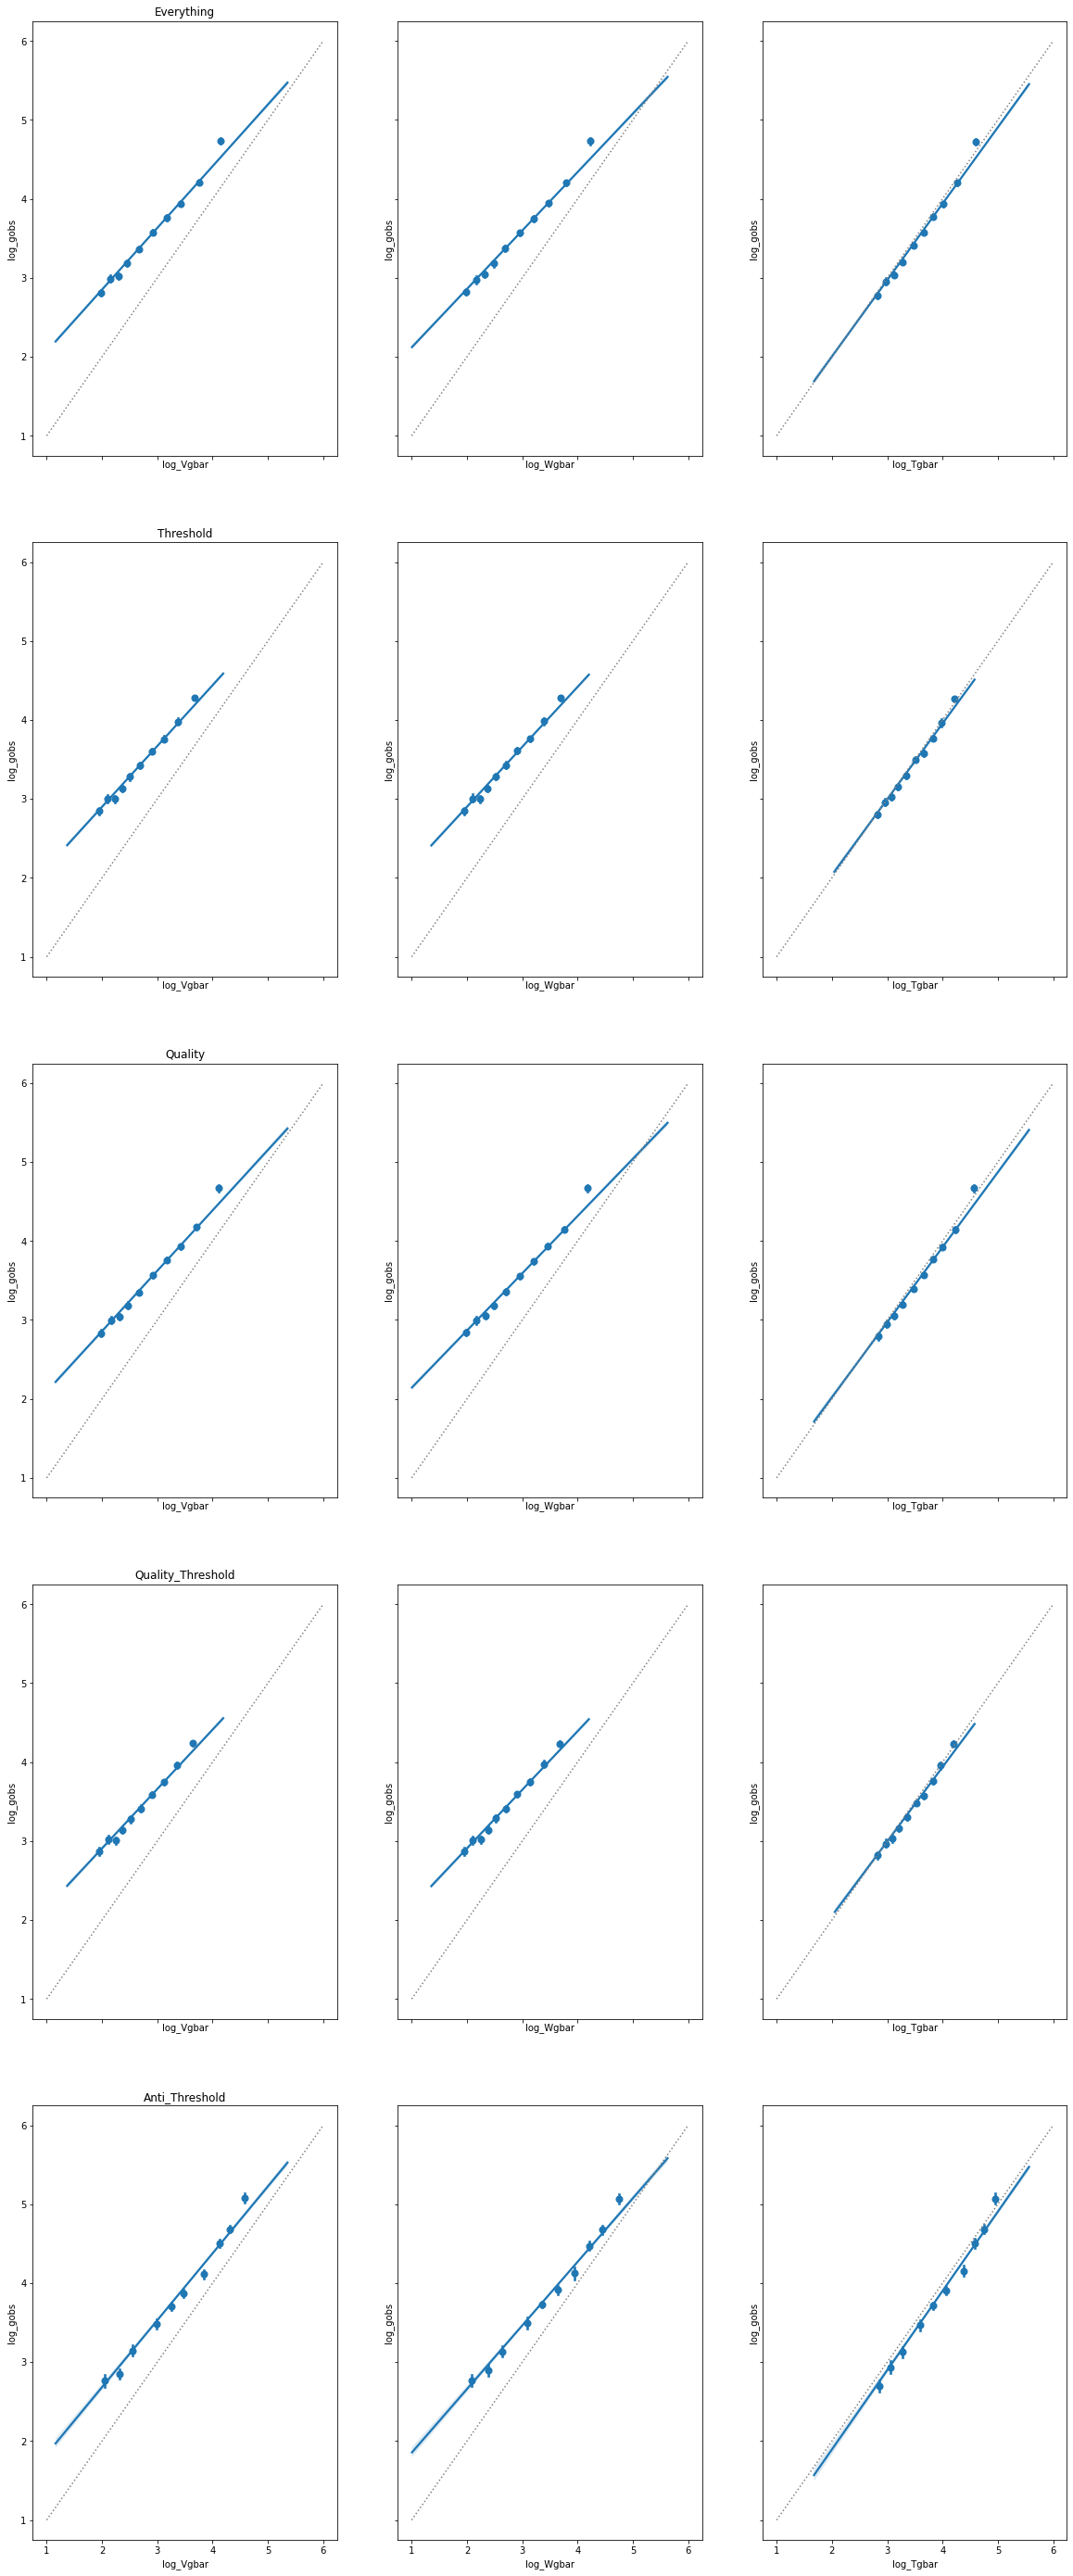

In [5]:
found.plot_rars(query_key=DATASET)

,iden,check,r2,rslope,rstderr,rintercept
0,V,rel_R,0.377928,-0.882820,0.022675,2.101428
1,V,Fnulled,0.460430,0.296297,0.006421,0.790155
2,V,mhi_R,0.271269,-0.385806,0.012660,1.827793
3,V,R,0.389663,-0.502310,0.012586,2.104331
4,V,D,0.011801,-0.105758,0.019375,1.856968
5,V,MHI,0.002447,-0.033702,0.013622,1.750897
6,W,rel_R,0.352271,-0.813877,0.022094,2.052739
7,W,Fnulled,0.433816,0.274631,0.006281,0.839173
8,W,mhi_R,0.242135,-0.348057,0.012328,1.798626
9,W,R,0.357288,-0.459292,0.012333,2.052623


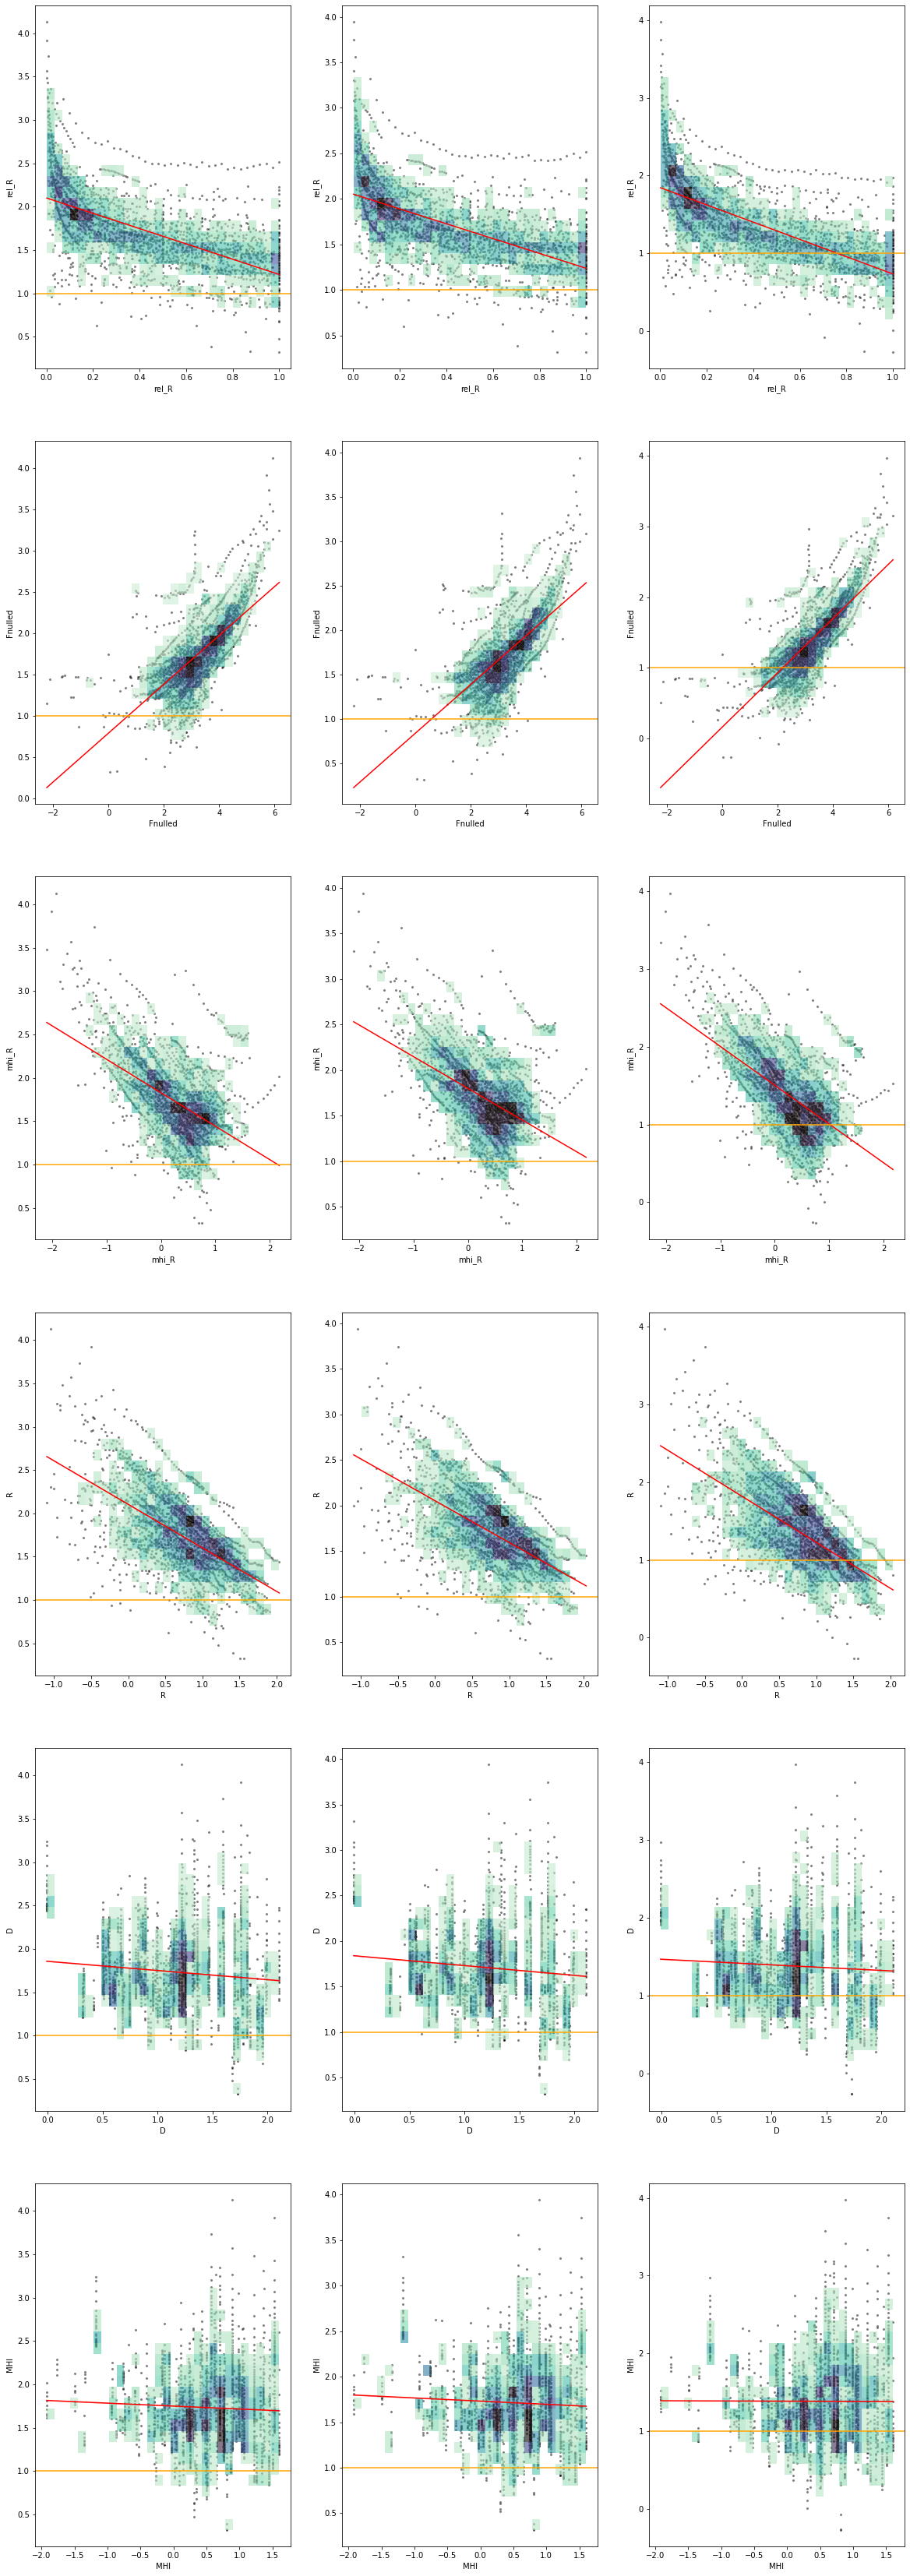

In [10]:
found.plot_residuals(query_key=DATASET)

In [2]:
from references.sparc import adjustment_df
adjs = adjustment_df()

In [61]:
adjs = adjs[adjs['Galaxy'].isin(mcmc_adjs['Galaxy'])]
adjs = pd.concat([adjs,mcmc_adjs], ignore_index=True)

In [11]:
def plot_comparison(dfs, what_sources, compare, to_source='SPARC', sort=None, x_sort='Galaxy'):
    fig, axes = plt.subplots(3, 1, figsize=(20,10))
    
    # sort correctly
    to_df = dfs[dfs['Source']==to_source].sort_values(compare)
    indx = to_df.set_index(x_sort)
    indx['sort'] = np.arange(len(indx))
    
    for i, what_source in enumerate(what_sources):
        what_df = dfs[dfs['Source']==what_source]
        
        # 1. Absolutes
        ax = axes[0]
        
        # continue sort for both what's
        what_df = what_df.join(indx[['sort']], on=x_sort).sort_values('sort')
        
        # only plot reference once
        if i == 0:
            tx, ty, te = to_df[x_sort], to_df[compare], to_df["e_%s" % compare]
            ax.fill_between(tx, ty-2*te, ty+2*te, color='whitesmoke')
            ax.fill_between(tx, ty-te, ty+te, color='lightgrey')
            sns.lineplot(x=tx, y=ty, label=to_source, color='grey', ax=ax)
            sns.scatterplot(x=tx, y=ty, color='grey', ax=ax)
        
        color = ['teal', 'orange'][i]
        wx, wy, we = what_df[x_sort], what_df[compare], what_df["e_%s" % compare]    
        g = sns.scatterplot(data=what_df, x=wx, y=compare, label=what_source, ax=ax, color=color)
        g.errorbar(wx, wy, yerr=we, ecolor=color, fmt='.k', color=color)
        
        ax.set(xticklabels=[])
        
        # 2. Ratios
        ax = axes[1]
        yy = np.array(wy)/np.array(ty)
        if i == 0:
            ax.fill_between(tx, (ty-2*te)/ty, (ty+2*te)/ty, color='whitesmoke')
            ax.fill_between(tx, (ty-te)/ty, (ty+te)/ty, color='lightgrey')
        sns.scatterplot(x=tx, y=yy, ax=ax, color=color)
        ax.set(xticklabels=[])
        
        # 3. Histogram
        ax = axes[2]
        sns.histplot(yy, ax=ax, color=color)

